# Covid19 확진자 시계열 분석

## #01. 작업 준비

### 패키지 참조하기

In [1]:
import sys
sys.path.append("../../helper")
from AnalysisHelper import helper

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

### 데이터 가져오기

In [2]:
origin = read_excel("https://data.hossam.kr/E06/covid19_seoul_230531.xlsx")
origin.head()

,서울시 기준일,서울시 확진자,서울시 추가 확진,서울시 치료중,서울시 퇴원,서울시 추가 퇴원,서울시 사망,서울시 의심환자 전체,서울시 의심환자 검사중,서울시 의심환자 검사결과(음성),...,전국 의심환자 전체,전국 의심환자 검사중,전국 의심환자 검사결과(음성),자가격리자 해외입국자 감시중,자가격리자 해외입국자 감시해제,자가격리자 접촉자 감시중,자가격리자 접촉자 감시해제,확인중 확진자,서울시 당일사망자,전국 당일 사망자
0,2023-05-31,6204277,5987.0,0,NaN,NaN,6492,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.0,17.0
1,2023-05-30,6198290,3326.0,0,NaN,NaN,6486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,7.0
2,2023-05-29,6194964,1393.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0
3,2023-05-28,6194964,1393.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0
4,2023-05-27,6191196,4078.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.0


## #02. 데이터 전처리

### 필요한 데이터만 추출

In [3]:
df = origin.filter(['서울시 기준일', '서울시 추가 확진'])
df.rename(columns={'서울시 기준일':'date', '서울시 추가 확진':'confirmed'}, inplace=True)
df.head()

,date,confirmed
0,2023-05-31,5987.0
1,2023-05-30,3326.0
2,2023-05-29,1393.0
3,2023-05-28,1393.0
4,2023-05-27,4078.0


### 각 필드의 데이터 타입 확인

외부에서 가져온 데이터는 항상 원하는 타입인지 확인 후 필요하다면 타입 변환을 거쳐야 한다.

In [4]:
df.dtypes

date          object
confirmed    float64
dtype: object

### 날짜 타입에 대한 형변환

In [5]:
df['date'] = to_datetime(df['date'].str.strip(), format='%Y-%m-%d')
df.dtypes

date         datetime64[ns]
confirmed           float64
dtype: object

### 결측치 검사

In [6]:
df.isna().sum()

date         0
confirmed    1
dtype: int64

### 결측치 정제

결측치인 경우는 확진자 발생하지 않은 것으로 간주하고 `0`으로 치환

In [7]:
df2 = df.fillna(0)
df2.isna().sum()

date         0
confirmed    0
dtype: int64

### `date` 필드를 날짜 형식의 인덱스로 지정

> helper 기능 활용

In [8]:
df3 = helper.set_datetime_index(df2, 'date')
df3.head()

,confirmed
2020-02-05,0.0
2020-02-06,0.0
2020-02-07,0.0
2020-02-08,0.0
2020-02-09,0.0


## #03. 데이터 검정

이상치는 보이지만 데이터 자체가 실제 발생한 현상이었으므로 정상 데이터로 판단함

결측치 수: 0


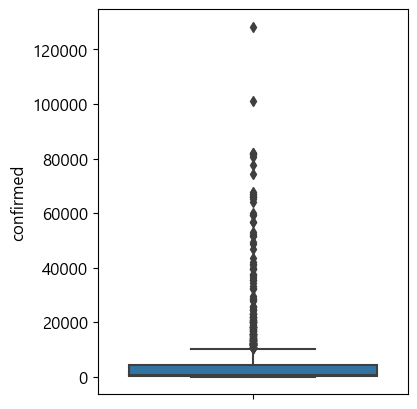

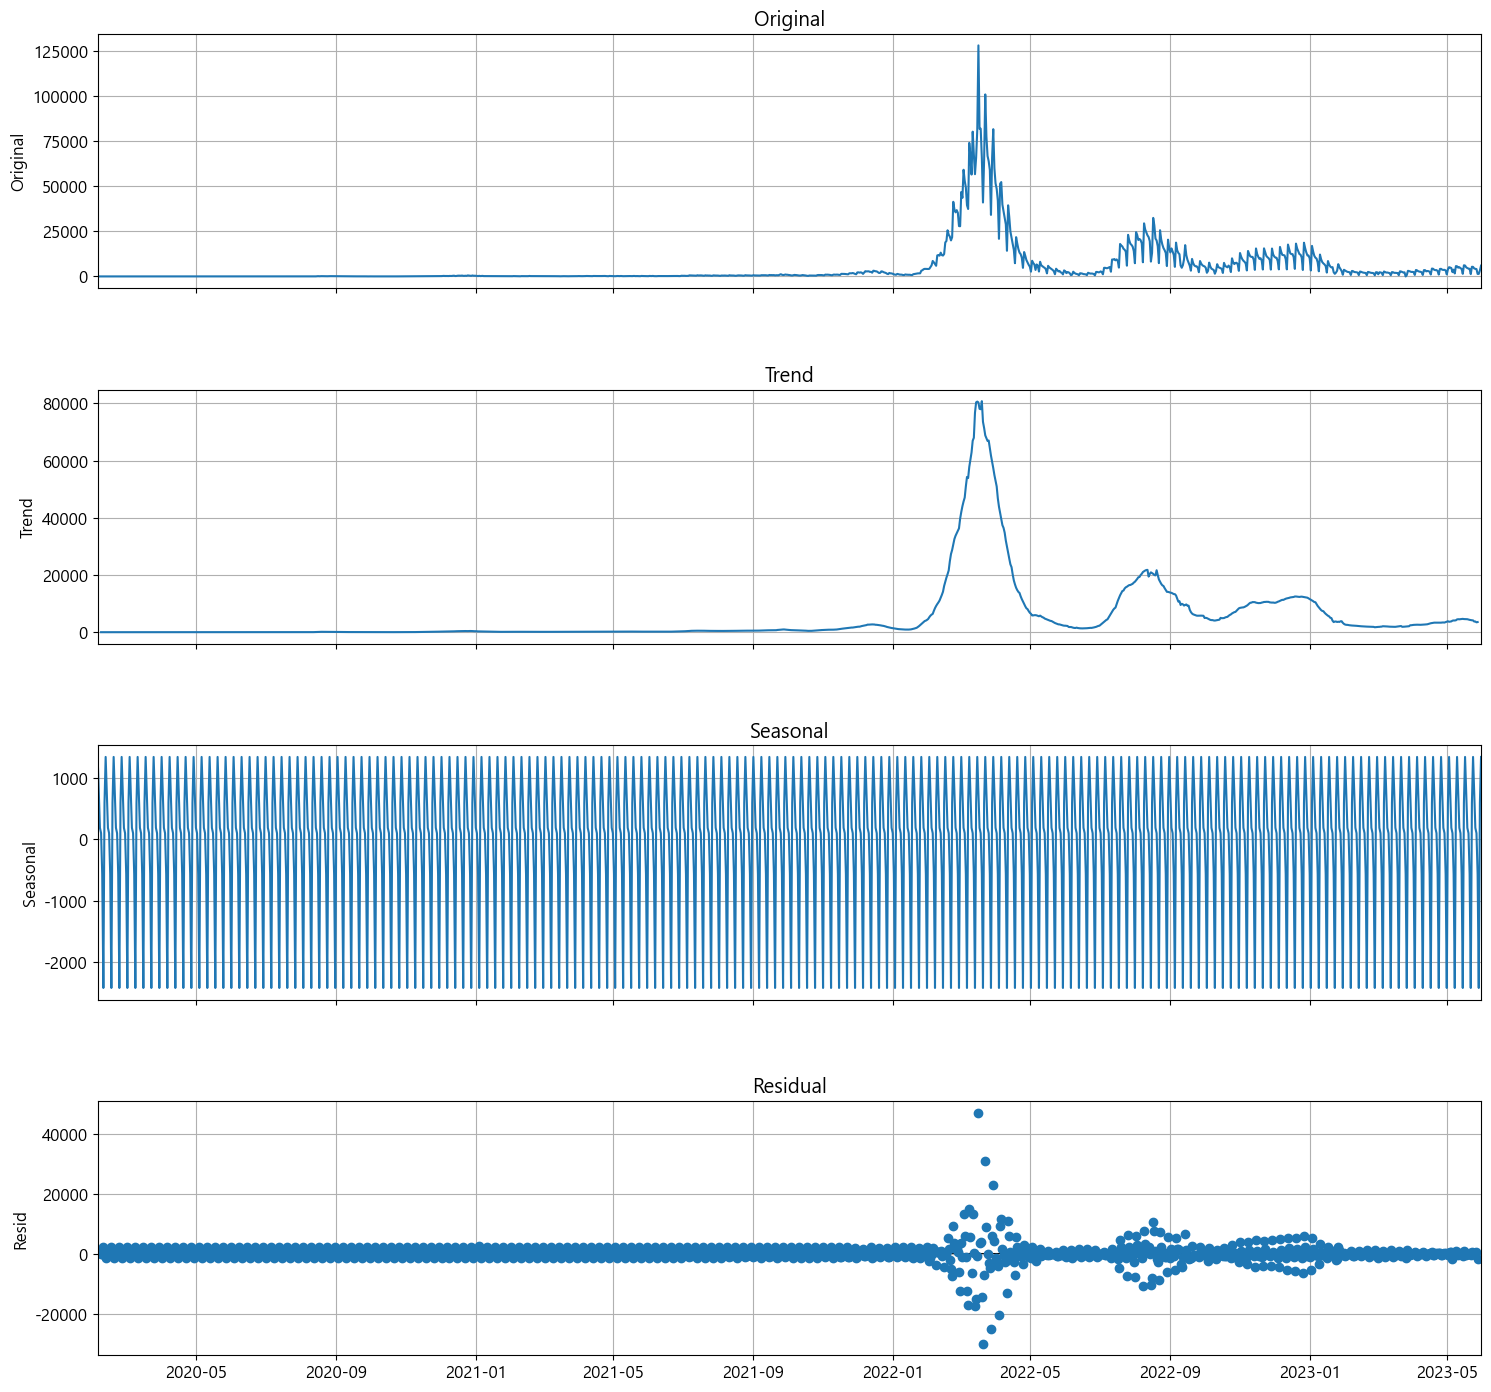

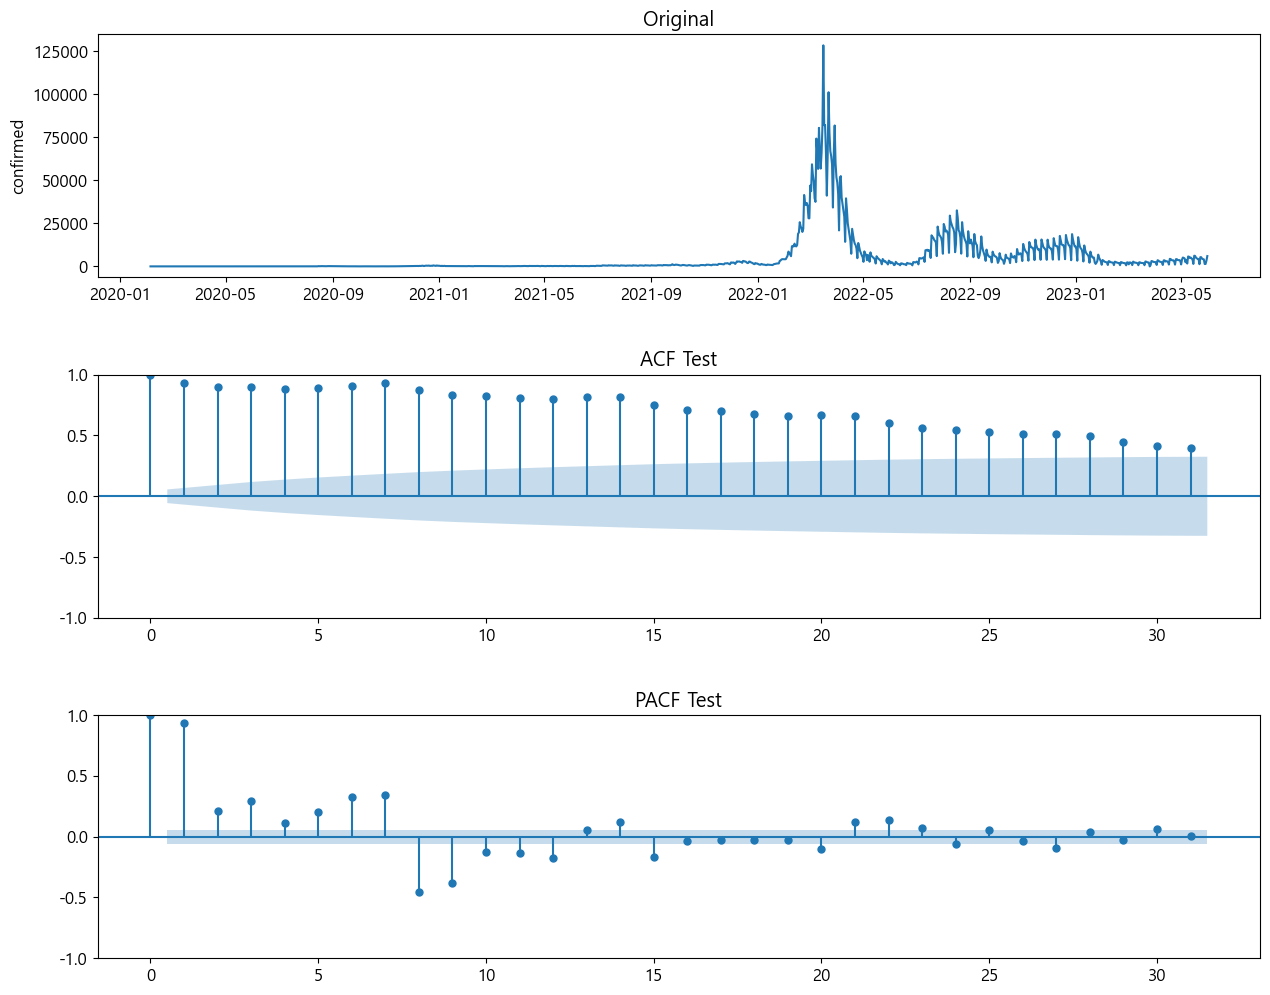

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -4.11626 |
| 유의수준(p-value)                  | 0.000910279 |
| 최적차수(num of lags)              |          23 |
| 관측치 개수(num of observations)   |        1188 |
| 기각값(Critical Values) 1%         |    -3.43587 |
| 기각값(Critical Values) 5%         |    -2.86398 |
| 기각값(Critical Values) 10%        |    -2.56807 |
| 데이터 정상성 여부(0=Flase,1=True) |           1 |
+------------------------------------+-------------+


In [9]:
helper.exp_time_data(data=df3, yname='confirmed', sd_model='a')

## #04. ARIMA 분석

### 분석모델 만들기

In [10]:
model = ARIMA(df3['confirmed'], order=(1,0,0), seasonal_order=(1,0,0,7))
fit = model.fit()
print(fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                       confirmed   No. Observations:                 1212
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -11572.350
Date:                         Tue, 08 Aug 2023   AIC                          23152.700
Time:                                 09:50:56   BIC                          23173.100
Sample:                             02-05-2020   HQIC                         23160.381
                                  - 05-31-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5119.1138   2109.541      2.427      0.015     984.489    9253.738
ar.L1          0.7469      0.006    118.058      0.000     

### 잔차 분석

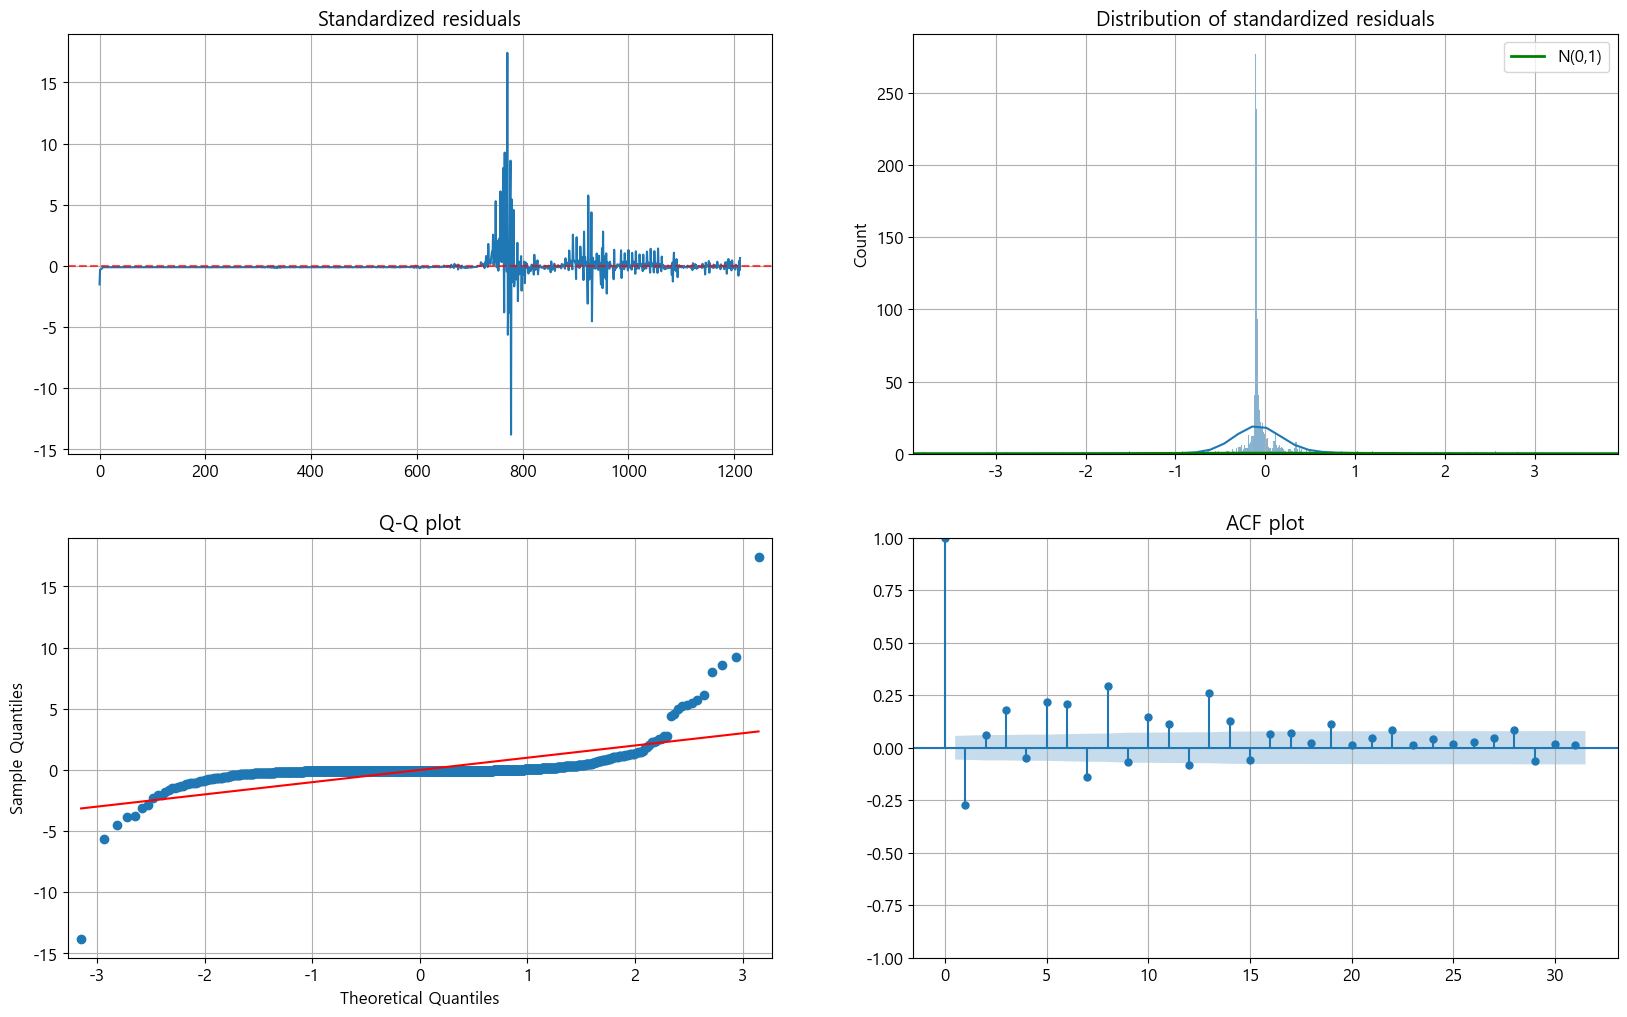

In [11]:
helper.arima_diagnostics(fit.resid)

### 학습 데이터에 대한 예측치

학습한 데이터에 대한 `predict()` 함수의 결과값을 내장하고 있다.

In [12]:
fv = fit.fittedvalues
fv.head()

2020-02-05    5119.113824
2020-02-06    1037.069449
2020-02-07     959.246146
2020-02-08     861.651335
2020-02-09     741.551616
Freq: D, dtype: float64

In [13]:
### 학습한 내용을 토대로 이후 120일간의 예상치 생성

In [14]:
fc = fit.forecast(120)
fc.head()

2023-06-01    5172.145660
2023-06-02    4877.622197
2023-06-03    4674.759850
2023-06-04    2668.118690
2023-06-05    2610.674418
Freq: D, Name: predicted_mean, dtype: float64

### 시각화

In [15]:
last = df3.index.max()
xmin = last-timedelta(days=120)
xmax = last+timedelta(days=120+10)
ymax = df3['confirmed'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-10-08 00:00:00'), 6198.0)

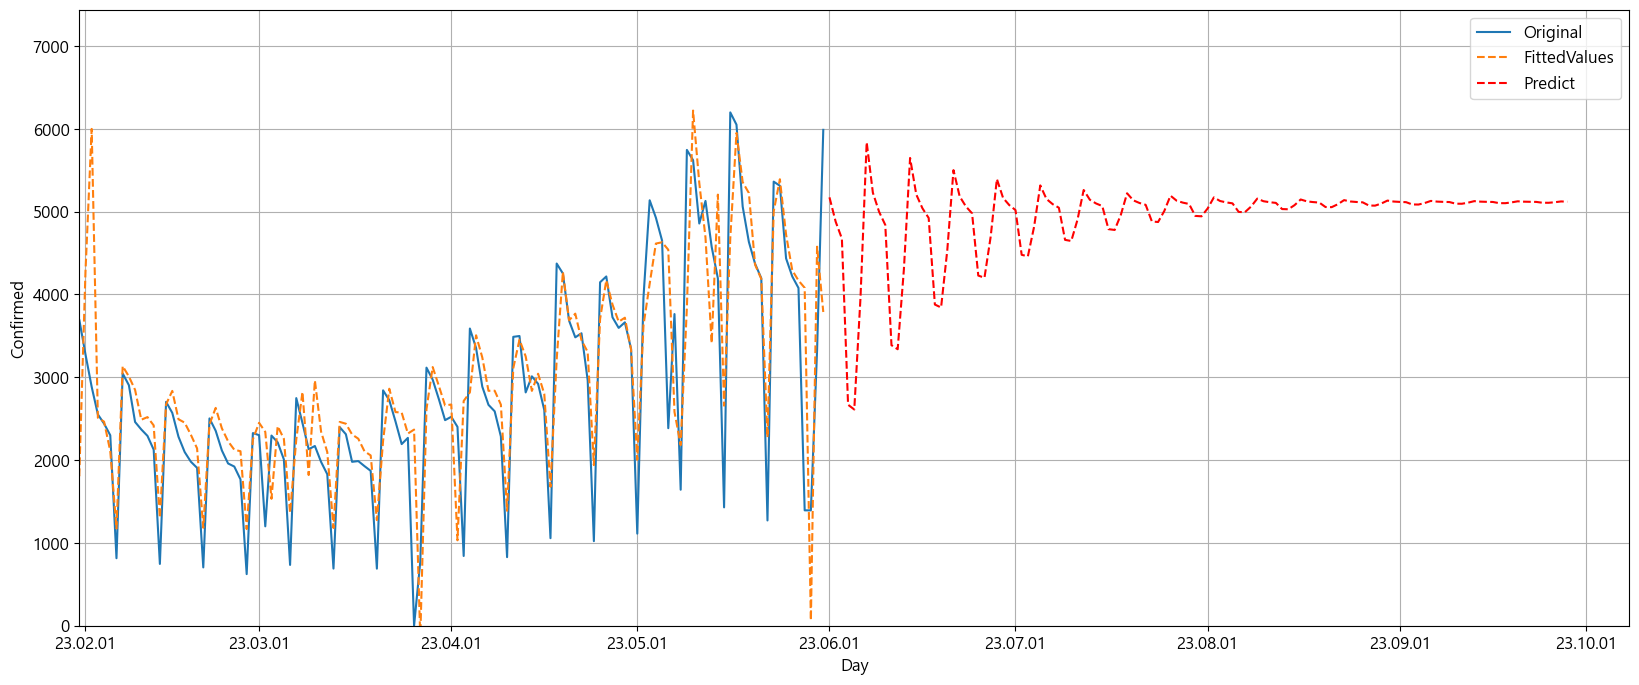

In [16]:
plt.figure(figsize=(20,8))

# 원본 데이터
sb.lineplot(data=df3, x=df3.index, y='confirmed', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 120일간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

## #04. AutoARIMA 분석

### 분석 수행

> 수집한 데이터 전체를 적용

In [17]:
my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 0    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 7    # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y=df3['confirmed'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=26229.494, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=23152.696, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=26427.372, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=23752.801, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=23793.364, Time=0.93 sec
 ARIMA(1,0,0)(1,0,0)[7]             : AIC=23163.519, Time=0.42 sec

Best model:  ARIMA(1,0,0)(1,0,0)[7] intercept
Total fit time: 2.231 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1212
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -11572.348
Date:                           Tue, 08 Aug 2023   AIC                          23152.696
Time:                                   09:51:02   BIC                          23173.096
Sample:                     

### 잔차분석

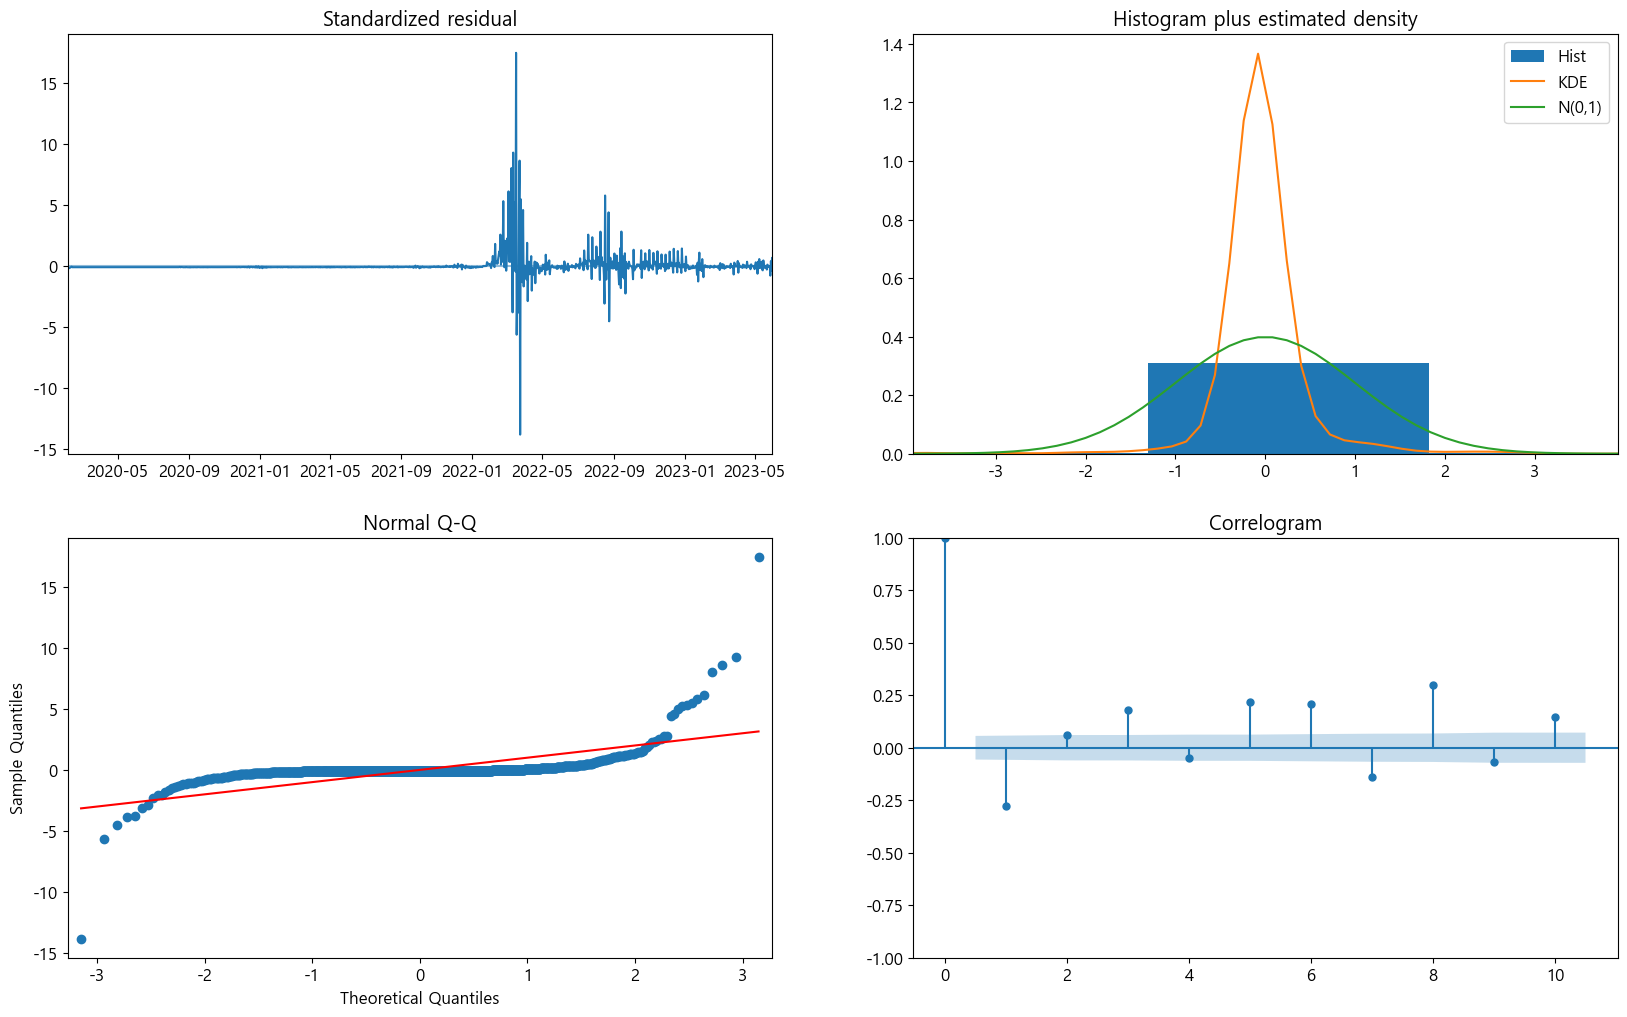

In [18]:
model.plot_diagnostics(figsize=(20, 12))
plt.show()

### 학습한 데이터와 동일 기간에 대한 예측치 산정

In [19]:
fv = model.fittedvalues()
fv.head()

2020-02-05    4971.995254
2020-02-06    1007.070260
2020-02-07     931.477784
2020-02-08     836.685212
2020-02-09     720.039704
Freq: D, dtype: float64

### 향후 120일간의 예측치 

In [20]:
fc = model.predict(n_periods=120)
fc.head()

2023-06-01    5161.596538
2023-06-02    4859.241954
2023-06-03    4650.529336
2023-06-04    2639.199302
2023-06-05    2578.496296
Freq: D, dtype: float64

### 시각화

In [21]:
last = df3.index.max()
xmin = last-timedelta(days=120)
xmax = last+timedelta(days=120+10)
ymax = df3['confirmed'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-10-08 00:00:00'), 6198.0)

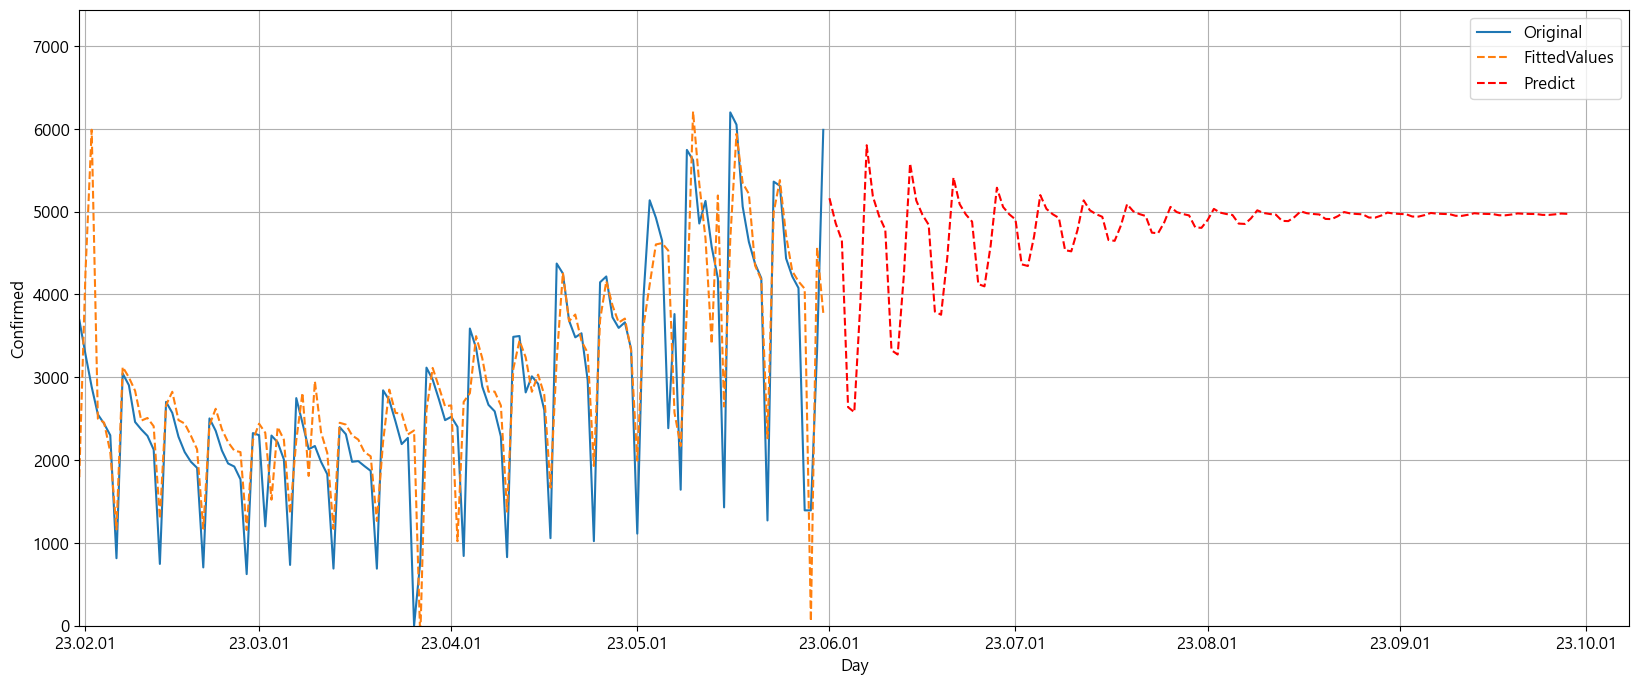

In [22]:
plt.figure(figsize=(20,8))

# 원본 데이터
sb.lineplot(data=df3, x=df3.index, y='confirmed', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 120일간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()